# Weather prediction example

This notebook shows a way to forecast time series data using a PredictLite framework.

(c) Mikko Kursula 2022 - 2024. MIT License. 

In [1]:
# Enable automatic reloading (if changes are done in the model code)
%load_ext autoreload
%autoreload 2

# General
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Data source
import meteostat

# PredictLite
from predictlite.predictlite import PredictLite

### Get weather dataset

In [2]:
# Get hourly weather data
station_id = '02944'
start_dt = datetime(2019, 1, 1)
end_dt = datetime(2024, 1, 1)
dataset = meteostat.Hourly(station_id, start_dt, end_dt).fetch()
dataset.head()

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2019-01-01 00:00:00,0.5,0.4,99.0,NaN,NaN,190.0,16.6,31.5,995.6,NaN,17.0
2019-01-01 01:00:00,0.5,0.4,99.0,NaN,NaN,190.0,13.0,31.5,994.1,NaN,5.0
2019-01-01 02:00:00,0.6,0.6,100.0,NaN,NaN,190.0,13.0,29.6,991.9,NaN,5.0
2019-01-01 03:00:00,1.0,0.9,99.0,NaN,NaN,180.0,13.0,27.8,989.5,NaN,5.0
2019-01-01 04:00:00,1.1,1.1,100.0,NaN,NaN,190.0,11.2,25.9,987.7,NaN,5.0


### Create categorical features

In [3]:
dataset['prcp'] = dataset['prcp'].fillna(0)
dataset['prcp_cat'] = (dataset['prcp'] > 0).astype(str)
dataset['wspd_cat'] = (dataset['wspd'] > 5).astype(str)

### Setup and train PredictLite model 

In [4]:
model = PredictLite(
    input_signals=['temp', 'rhum'], 
    input_preprocessing={'temp' : 'z-norm', 'rhum' : 'z-norm'},
    datetime_embeddings=['month', 'hour'],
    datetime_embedding_dim=6,
    categorical_inputs=['wspd_cat', 'prcp_cat'],
    categorical_embedding_dim=4,
    input_length=72, 
    output_signals=['temp', 'rhum'],
    output_length=24,
    data_sample_period=3600,
    sequential_layer_neurons=[20],
    longitudinal_layer_neurons=[20],
    flattened_layer_neurons=[30, 30],
    percentiles=[0.25, 0.75],
    smoothing_weight=0.1
)

In [5]:
model.fit(
    data=dataset,
    train_sample_n=10000,
    test_sample_n=1000,
    epochs=20,
    learning_rate=0.0003,
    random_seed=13,
    verbose=True,
)

Setting up preprocessing
Building dataset
Training the model
epoch:   0, train loss: 0.98634, test loss: 0.73692
epoch:   1, train loss: 0.63673, test loss: 0.58459
epoch:   2, train loss: 0.53330, test loss: 0.47500
epoch:   3, train loss: 0.46841, test loss: 0.42960
epoch:   4, train loss: 0.44082, test loss: 0.42020
epoch:   5, train loss: 0.42914, test loss: 0.41468
epoch:   6, train loss: 0.42499, test loss: 0.40792
epoch:   7, train loss: 0.42188, test loss: 0.40742
epoch:   8, train loss: 0.41857, test loss: 0.40618
epoch:   9, train loss: 0.41671, test loss: 0.40360
epoch:  10, train loss: 0.41401, test loss: 0.40182
epoch:  11, train loss: 0.41145, test loss: 0.40553
epoch:  12, train loss: 0.41102, test loss: 0.40627
epoch:  13, train loss: 0.40914, test loss: 0.39992
epoch:  14, train loss: 0.40791, test loss: 0.40176
epoch:  15, train loss: 0.40663, test loss: 0.40036
epoch:  16, train loss: 0.40504, test loss: 0.39510
epoch:  17, train loss: 0.40374, test loss: 0.39526
epo

In [6]:
model.model_summary()

Inputs:
	Float inputs: ['temp', 'rhum']
	Time steps: 72
	month_emb: num_embeddings: 13, embedding_dim: 6
	hour_emb: num_embeddings: 25, embedding_dim: 6
	wspd_cat: num_embeddings: 3, embedding_dim: 4
	prcp_cat: num_embeddings: 3, embedding_dim: 4
MLP sequential part:
	Linear(in_features=22, out_features=20, bias=True), parameter count: 460
	ReLU()
	Flatten(start_dim=-2, end_dim=-1)
MLP longitudinal part:
	Linear(in_features=72, out_features=20, bias=True), parameter count: 1460
	ReLU()
	Flatten(start_dim=-2, end_dim=-1)
MLP flattened part:
	Linear(in_features=1880, out_features=30, bias=True), parameter count: 56430
	ReLU()
	Linear(in_features=30, out_features=30, bias=True), parameter count: 930
	ReLU()
	Linear(in_features=30, out_features=144, bias=True), parameter count: 4464

Total MLP parameter count: 63744


### Make prediction

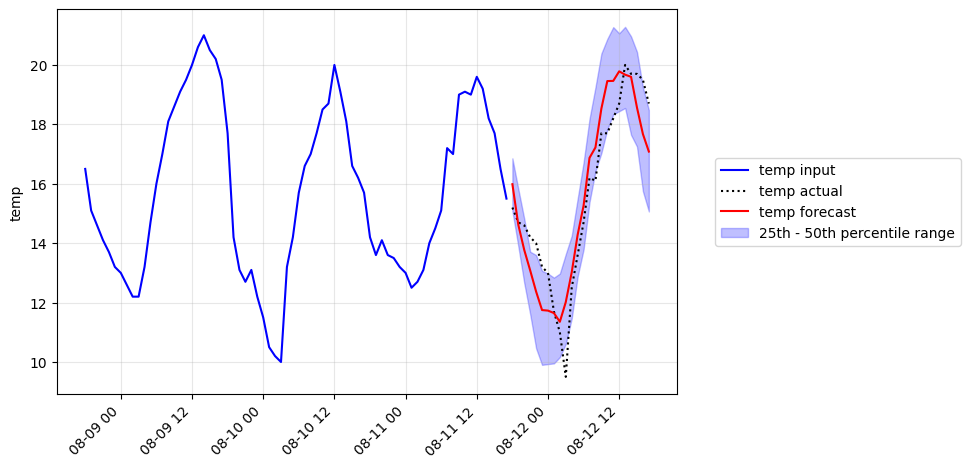

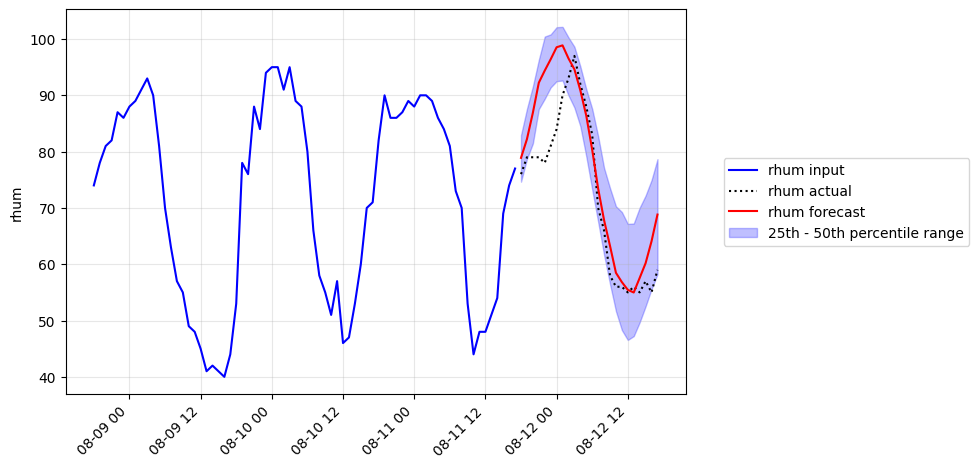

In [7]:
# Give datetime for prediction
prediction_time = datetime(2023, 8, 11, 17)

# Make prediction 
predictions = model.predict(dataset, prediction_time)

# Plot everything
for col in model.output_signals:
    ts_idx = dataset.index.get_indexer([prediction_time], method='pad')[0] + 1
    plt.figure(figsize=(8, 5))
    plt.plot(
        dataset.index[ts_idx - model.input_length : ts_idx].values, 
        dataset.iloc[ts_idx - model.input_length : ts_idx][col].values, 
        color='blue', 
        label='{} input'.format(col)
    )
    plt.plot(
        dataset.index[ts_idx : ts_idx + model.output_length].values, 
        dataset.iloc[ts_idx : ts_idx + model.output_length][col].values, 
        color='black',
        ls=':',
        label='{} actual'.format(col)
    )
    plt.plot(
        predictions['prediction'].index.values, 
        predictions['prediction'][col].values, 
        color='red', 
        label='{} forecast'.format(col)
    )
    plt.fill_between(
        predictions['lower_percentile'].index.values, 
        y1=predictions['lower_percentile'][col].values, 
        y2=predictions['upper_percentile'][col].values,
        color='blue', 
        alpha=0.25,
        label='25th - 50th percentile range'
    )
    plt.xticks(rotation=45, ha='right')
    plt.ylabel(col)
    plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
    plt.grid(alpha=0.3)
    plt.show()